<a href="https://colab.research.google.com/github/Abbessi-zouhour/drug_solubility/blob/master/solubility3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install py3Dmol rdkit-pypi

In [2]:
!pip install "numpy<2"

In [3]:
!pip install deepchem

In [4]:
!pip install rdkit-pypi

In [5]:
!pip install py3Dmol

In [6]:
!pip install py3Dmol --upgrade


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


ESOL Dataset Tasks: ['measured log solubility in mols per litre']
Number of training samples: 902
Number of validation samples: 113
Number of test samples: 113

Solubility (logS) Statistics:
Mean: -0.02
Min: -4.09
Max: 2.19
Std Dev: 1.00


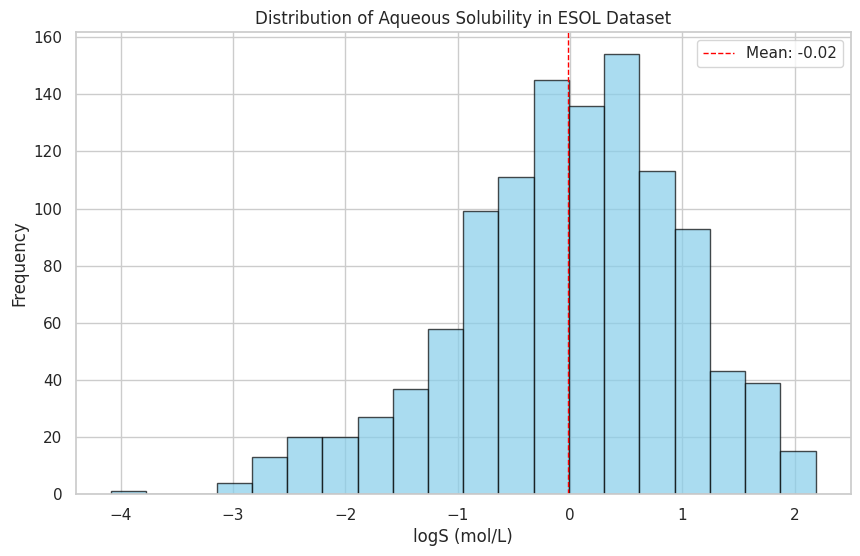

SMILES,Structure,Property
CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O,,logS: -0.418
ClC(Cl)(Cl)N(=O)=O,,logS: 0.483
CC(C)C(O)C(C)C,,logS: 0.854
O=C1CCC(=O)N1,,logS: 1.578
O2c1ccc(N)cc1N(C)C(=O)c3cc(C)ccc23,,logS: -0.435
Cc1ccccc1,,logS: 0.383
c1ccnnc1,,logS: 1.959
OCC(NC(=O)C(Cl)Cl)C(O)c1ccc(cc1)N(=O)=O,,logS: 0.430
CC#N,,logS: 1.559
CN(C)C(=O)Nc1ccc(c(Cl)c1)n2nc(oc2=O)C(C)(C)C,,logS: -0.626

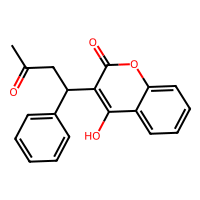
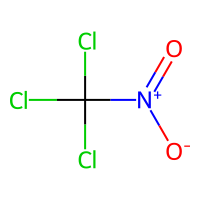
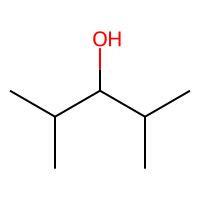
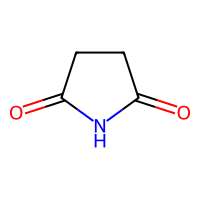
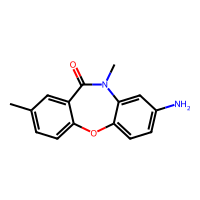
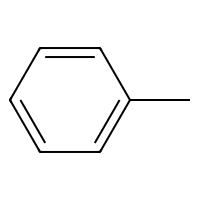
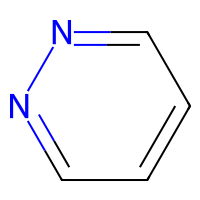
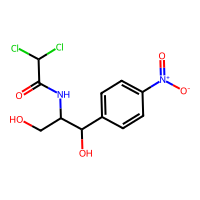
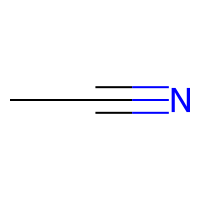
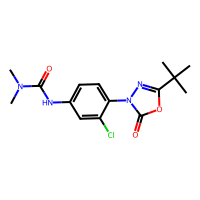

Test MSE: 1.5764
Test RMSE: 1.2555


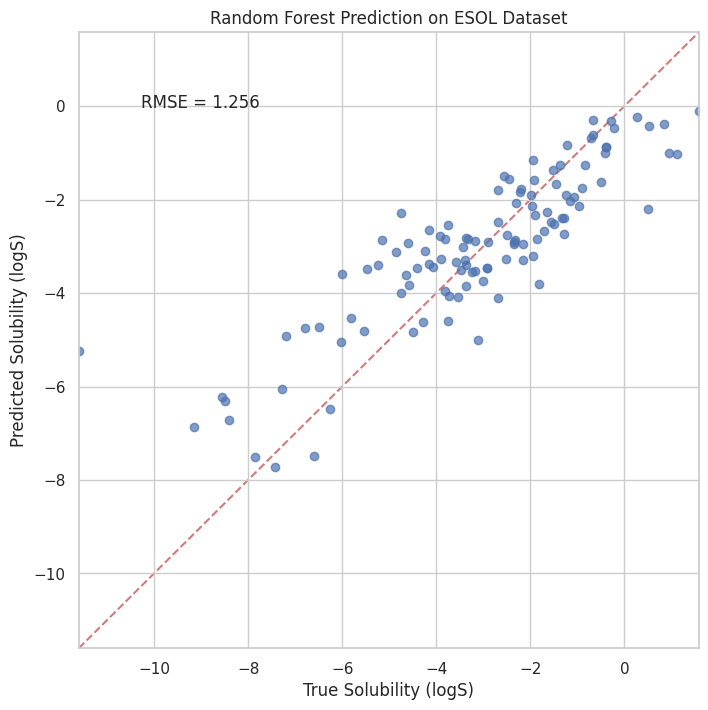

In [7]:
# ------------------ Imports ------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Draw
import io, base64
from PIL import Image
from IPython.display import HTML, display
import warnings
import deepchem as dc
from deepchem.feat import CircularFingerprint
from deepchem.molnet import load_delaney
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from google.colab.output import enable_custom_widget_manager
enable_custom_widget_manager()
from IPython.display import display



plt.style.use('ggplot')
sns.set_theme(style="whitegrid")

from rdkit import rdBase
rdBase.DisableLog('rdApp.warning')
warnings.filterwarnings('ignore', category=UserWarning, module='deepchem')

# ------------------ Function for table ------------------
def create_molecule_table(dataset, n=12, label_type='regression', task_name=None):
    data = []
    num_to_display = min(n, len(dataset))

    for i in range(num_to_display):
        smi = dataset.ids[i]
        mol = Chem.MolFromSmiles(smi)

        img_html = "Invalid SMILES"
        if mol is not None:
            try:
                img = Draw.MolToImage(mol, size=(200, 200))
                buf = io.BytesIO()
                img.save(buf, format="PNG")
                img_b64 = base64.b64encode(buf.getvalue()).decode('utf-8')
                img_html = f'<img src="data:image/png;base64,{img_b64}" width="200" height="200"/>'
            except Exception as e:
                img_html = f"Image Generation Error: {e}"

        label_val = dataset.y[i]
        label_str = "N/A"
        if label_val is not None and hasattr(label_val, '__len__') and len(label_val) > 0:
            val_to_format = label_val[0]
            if label_type == 'regression':
                try:
                    label_str = f"{val_to_format:.3f}"
                except (TypeError, ValueError):
                    label_str = str(val_to_format)
            elif label_type == 'classification':
                try:
                    label_str = "Active" if int(val_to_format) == 1 else "Inactive"
                except (TypeError, ValueError):
                    label_str = str(val_to_format)
            else:
                label_str = str(val_to_format)
        elif label_val is not None:
            label_str = str(label_val)

        property_label = f"{task_name}: {label_str}" if task_name else label_str
        data.append([smi, img_html, property_label])

    df = pd.DataFrame(data, columns=["SMILES", "Structure", "Property"])
    return df
# ------------------ Load ESOL dataset ------------------
tasks_esol, datasets_esol_raw, transformers_esol = load_delaney(
    featurizer='Raw',
    splitter='random',
    reload=True
)
train_esol_raw, valid_esol_raw, test_esol_raw = datasets_esol_raw

print(f"ESOL Dataset Tasks: {tasks_esol}")
print(f"Number of training samples: {len(train_esol_raw)}")
print(f"Number of validation samples: {len(valid_esol_raw)}")
print(f"Number of test samples: {len(test_esol_raw)}")

y_all_esol = np.concatenate([train_esol_raw.y, valid_esol_raw.y, test_esol_raw.y])
print("\nSolubility (logS) Statistics:")
print(f"Mean: {np.mean(y_all_esol):.2f}")
print(f"Min: {np.min(y_all_esol):.2f}")
print(f"Max: {np.max(y_all_esol):.2f}")
print(f"Std Dev: {np.std(y_all_esol):.2f}")

plt.figure(figsize=(10, 6))
plt.hist(y_all_esol, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(np.mean(y_all_esol), color='red', linestyle='dashed', linewidth=1, label=f'Mean: {np.mean(y_all_esol):.2f}')
plt.xlabel('logS (mol/L)')
plt.ylabel('Frequency')
plt.title('Distribution of Aqueous Solubility in ESOL Dataset')
plt.legend()
plt.show()

df_esol = create_molecule_table(train_esol_raw, n=10, label_type='regression', task_name='logS')
try:
    display(HTML(df_esol.to_html(escape=False, index=False)))
except NameError:
    print(df_esol.to_string())

# ------------------ ECFP featurization & modeling ------------------
featurizer_esol = CircularFingerprint(radius=2, size=1024)
tasks_esol, datasets_esol, transformers_esol = load_delaney(
    featurizer=featurizer_esol,
    splitter='random',
    transformers=[],
    reload=True
)
train_esol, valid_esol, test_esol = datasets_esol

rf_esol = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model_esol = dc.models.SklearnModel(rf_esol)
model_esol.fit(train_esol)

preds_esol = model_esol.predict(test_esol).flatten()
y_true_esol = test_esol.y.flatten()

mse_esol = mean_squared_error(y_true_esol, preds_esol)
rmse_esol = np.sqrt(mse_esol)
print(f"Test MSE: {mse_esol:.4f}")
print(f"Test RMSE: {rmse_esol:.4f}")

plt.figure(figsize=(8, 8))
plt.scatter(y_true_esol, preds_esol, alpha=0.7)
plt.xlabel("True Solubility (logS)")
plt.ylabel("Predicted Solubility (logS)")
plt.title("Random Forest Prediction on ESOL Dataset")
lims = [min(np.min(y_true_esol), np.min(preds_esol)), max(np.max(y_true_esol), np.max(preds_esol))]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0)
plt.xlim(lims)
plt.ylim(lims)
plt.grid(True)
plt.text(lims[0]*0.9+lims[1]*0.1, lims[1]*0.9+lims[0]*0.1, f'RMSE = {rmse_esol:.3f}', ha='left', va='top')
plt.show()




**Please restart the runtime by going to `Runtime > Restart runtime` in the menu.**

After the runtime restarts, run the following cells to reinstall the packages in the correct order.

In [11]:
# ------------------ 3D visualization for all molecules ------------------
import py3Dmol
from IPython.display import display
from rdkit import Chem
from rdkit.Chem import AllChem

def show_3d_structure(smiles, title="Molecule"):
    try:
        mol = Chem.MolFromSmiles(smiles)
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        AllChem.UFFOptimizeMolecule(mol)
        mb = Chem.MolToMolBlock(mol)

        viewer = py3Dmol.view(width=400, height=300)
        viewer.addModel(mb, "mol")
        viewer.setStyle({'stick': {}})
        viewer.zoomTo()
        display(viewer)

    except Exception as e:
        print(f"Error rendering molecule {smiles}: {e}")


In [13]:
# Loop through first 10 molecules
for i, smi in enumerate(train_esol_raw.ids[:10]):
    label_val = train_esol_raw.y[i]
    if label_val is not None and hasattr(label_val, '__len__') and len(label_val) > 0:
        prop_str = f"{label_val[0]:.3f}"
    else:
        prop_str = "N/A"

    mol_title = f"Train molecule #{i+1}"

    df_row = pd.DataFrame([[smi, prop_str]], columns=["SMILES", "logS"])
    display(HTML(df_row.to_html(escape=False, index=False)))

    show_3d_structure(smi, title=mol_title)


SMILES,logS
CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O,-0.418


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

SMILES,logS
ClC(Cl)(Cl)N(=O)=O,0.483


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

SMILES,logS
CC(C)C(O)C(C)C,0.854


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

SMILES,logS
O=C1CCC(=O)N1,1.578


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

SMILES,logS
O2c1ccc(N)cc1N(C)C(=O)c3cc(C)ccc23,-0.435


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

SMILES,logS
Cc1ccccc1,0.383


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

SMILES,logS
c1ccnnc1,1.959


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

SMILES,logS
OCC(NC(=O)C(Cl)Cl)C(O)c1ccc(cc1)N(=O)=O,0.430


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

SMILES,logS
CC#N,1.559


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

SMILES,logS
CN(C)C(=O)Nc1ccc(c(Cl)c1)n2nc(oc2=O)C(C)(C)C,-0.626


3Dmol.js failed to load for some reason. Please check your browser console for error messages.